In [2]:
import sys
if 'init_modules' in globals().keys():
    # second or subsequent run: remove all but initially loaded modules
    for m in sys.modules.keys():
        if m not in init_modules:
            del(sys.modules[m])
else:
    # first run: find out which modules were initially loaded
    init_modules = sys.modules.keys()
import numpy as np
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import pyfilaments.analysisutils as analysis
from tqdm import tqdm
import pandas as pd
import h5py

%matplotlib notebook
plt.close('all')

# Figure parameters
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import cm
from tqdm import tqdm


# Create a folder for storing Publication figures

publication_figures = '/home/deepak/Dropbox/LacryModeling/ActiveFilamentsManuscript/Figures/Figure4'

import _figure_parameters


# Load data from full numerical simulations

In [14]:
# data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23']

# data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23']
# data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_FineResolution']

# data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweeps_diffActivityTimeScales_FINAL/activityTime_500']

data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ActivityTimeSweep_FINAL']

In [15]:
# Find all analysis data files and create a list
files_list = []
 # Walk through the folders and identify the simulation data files

for data_folder in data_folders:
    for dirs, subdirs, files in os.walk(data_folder, topdown=False):

        root, subFolderName = os.path.split(dirs)

        for fileNames in files:
            if(fileNames.endswith('hdf5') and fileNames[0] != '.' and 'analysis' in fileNames):
                files_list.append(os.path.join(dirs,fileNames))

print('No:of files: {}'.format(len(files_list)))

No:of files: 60


In [16]:
# Build a data frame with all the data and the parameter of interest

# Set the parameter of interest
# parameter = 'spring constant'
# parameter = 'activity number'
# parameter = 'potDipole strength'

parameter = 'activity timescale'

# Collect all data into a single data frame
df = pd.DataFrame({})


for file in files_list:

    with h5py.File(file, "r") as f:
        if('analysis data' in f.keys()): # Load the simulation data (newer method)
            
            
            dset = f['analysis data']
            
            if(dset.attrs['Sim complete']==True):
                
                parameter_value = dset.attrs[parameter]
                
                period = dset.attrs['period']
                if(np.isnan(period)):
                    period = 'aperiodic'
                tip_angles = dset['Tip angles'][-10:-1] # Look at fixed points in the last 10 cycles
                
                filament_behavior = dset.attrs['filament behavior']

                df_file = pd.DataFrame({parameter:np.repeat(parameter_value, len(tip_angles),axis=0), 'Base-Tip angles':tip_angles,'period':np.repeat(period, len(tip_angles),axis=0), 'filament behavior':np.repeat(filament_behavior, len(tip_angles),axis=0)})
                
              
                df = df.append(df_file, ignore_index=True)
                
                
df

,activity timescale,Base-Tip angles,period,filament behavior
0,625.0,-0.060758,aperiodic,aperiodic
1,625.0,-0.305180,aperiodic,aperiodic
2,625.0,0.143488,aperiodic,aperiodic
3,625.0,0.078445,aperiodic,aperiodic
4,625.0,0.240102,aperiodic,aperiodic
...,...,...,...,...
535,575.0,-0.518219,2,2n-period
536,575.0,0.012658,2,2n-period
537,575.0,-0.518267,2,2n-period
538,575.0,0.012702,2,2n-period


<IPython.core.display.Javascript object>


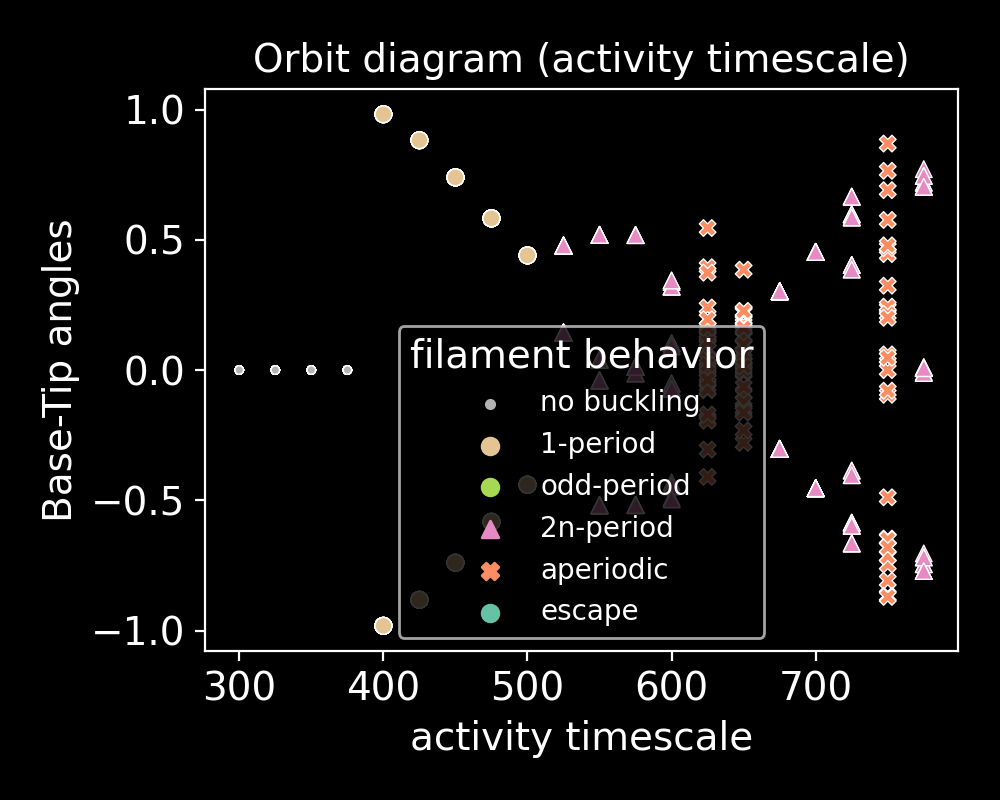

In [17]:
# Plot orbit diagram of filament base-tip angles (orbit point: phase=0 (end of extension, start of compression))
# Choose a consistent color-map and markers for filament behaviors
save = False

categories = ['no buckling', '1-period', 'odd-period','2n-period','aperiodic','escape']
markers = {'no buckling':'.', '1-period':'o','odd-period':'d','2n-period':'^','aperiodic':'X','escape':'$e$'}

cmap = plt.cm.get_cmap('Set2_r', 255)
linear_array = np.linspace(0,1,len(categories))
colors={}
for ii, cat in enumerate(categories):
    
    colors[cat]=cmap(linear_array[ii])
                           

style_parameter = 'filament behavior'

df['Base-tip angles (deg)'] = df['Base-Tip angles']*180/np.pi

# plt.style.use('default')
title = 'Orbit diagram ({})'.format(parameter)
plt.figure(figsize=(5,4))
sns.scatterplot(data = df, x = parameter, y = 'Base-Tip angles', hue = style_parameter, style = style_parameter, 
                estimator = None, legend= True, rasterized = True, hue_order = categories, markers = markers, palette = colors)
# sns.scatterplot(x = parameter, y = 'Base-Tip angles' , data = df,
#                 estimator = None, legend= True, palette = 'bright', rasterized = True, color = 'k', s=20)
plt.title(title)
plt.tight_layout()
# plt.yticks([-135, -90, -45, 0, 45, 90, 135])
if(save):
    plt.savefig(os.path.join(publication_figures, title + '.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title + '.svg'), dpi = 300)
plt.show()

In [57]:
# Save the Orbit map DataFrame
processed_data_folder = '/home/deepak/Dropbox/LacryModeling/processed_data/figures'
file = 'OrbitMap.csv'
df.to_csv(os.path.join(processed_data_folder, file))

In [18]:
# Fixed points based on Single-cycle prediction

# Plot the bifurcation diagram of the system

# Activity strength variation single-cycle prediction
# fixed_pts_data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/activity_strength_sweep_FINAL/FixedPointAnalysis'

# fixed_pts_data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/activity_strength_time_sweep_30_Jan_2022/activity_timescale_500/FixedPointAnalysis'

# Activity time variation single cycle prediction
fixed_pts_data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/ActivityTimeSweep_FINAL/FixedPointAnalysis' 

files = os.listdir(fixed_pts_data_folder)

df_combined = pd.DataFrame({})

for ii, file in enumerate(files):
    
    if file.endswith('.csv'):
        df_temp = pd.read_csv(os.path.join(fixed_pts_data_folder, file))
        
        if df_temp['activity number'][0]<=95 and df_temp['activity number'][0]>=40:
            df_combined = df_combined.append(df_temp)

In [19]:
# By symmetry, we can reflect the fixed-points about the axis of symmetry
df_combined['Fixed points -ve'] = -df_combined['Fixed point']

df_combined = df_combined.sort_values(by=['activity timescale'])

df_combined

,Unnamed: 0,Fixed point,Slope,type,activity number,activity timescale,dynamics,stability,Fixed points -ve
0,0,0.000000,0.528464,Positive,80.724,300.0,Zero fixed point,linearly stable,-0.000000
1,0,0.106255,1.182502,Positive,80.724,300.0,1-Period,unstable,-0.106255
1,0,0.047973,1.361069,Positive,80.724,325.0,1-Period,unstable,-0.047973
0,0,0.000000,0.288325,Positive,80.724,325.0,Zero fixed point,linearly stable,-0.000000
1,0,0.019657,1.661669,Positive,80.724,350.0,1-Period,unstable,-0.019657
0,0,0.000000,0.220235,Positive,80.724,350.0,Zero fixed point,linearly stable,-0.000000
1,0,0.007560,2.674643,Positive,80.724,375.0,1-Period,unstable,-0.007560
0,0,0.000000,0.876365,Positive,80.724,375.0,Zero fixed point,linearly stable,-0.000000
0,0,0.000000,3.158472,Positive,80.724,400.0,Zero fixed point,unstable,-0.000000
0,0,0.000000,7.916162,Positive,80.724,425.0,Zero fixed point,unstable,-0.000000


In [51]:
# Choose a subset of the simulation data to plot
df = df.loc[(df['activity number']>=25) & (df['activity number']<90)]

<IPython.core.display.Javascript object>


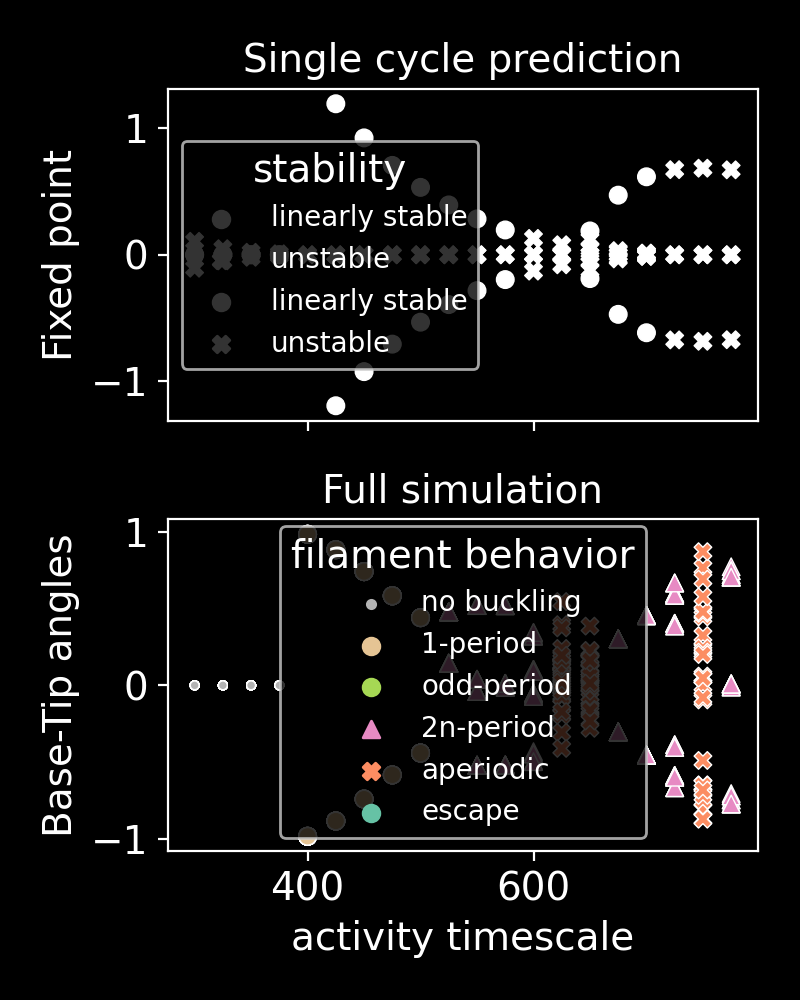

In [25]:
save = True
plt.style.use('dark_background')

# Choose the parameters of interest
style_parameter = 'filament behavior'
parameter = 'activity timescale'

categories = ['no buckling', '1-period', 'odd-period','2n-period','aperiodic','escape']
markers = {'no buckling':'.', '1-period':'o','odd-period':'o','2n-period':'^','aperiodic':'X'}

cmap = plt.cm.get_cmap('Set2_r', 255)
linear_array = np.linspace(0,1,len(categories))
colors={}
for ii, cat in enumerate(categories):
    
    colors[cat]=cmap(linear_array[ii])
                           
        
title = 'Bifurcation plot_predicted_vs_fullSim_activity_time_varying_dark_bcknd'
fig, (ax0, ax1) = plt.subplots(figsize=(4,5), nrows=2, ncols = 1, sharex=True)
sns.scatterplot(data = df, x = parameter, y = 'Base-Tip angles', hue = style_parameter, style = style_parameter, 
                estimator = None, legend= True, rasterized = True, hue_order = categories, markers = markers, 
                palette = colors, ax = ax1, s = 40)

sns.scatterplot(data = df_combined, x = parameter, y = 'Fixed point', 
                markers = {'linearly stable':'o','unstable':'X'},style = 'stability',color = 'w', ax=ax0, s= 40)

sns.scatterplot(data = df_combined, x = parameter, y = 'Fixed points -ve', 
                markers = {'linearly stable':'o','unstable':'X'},style = 'stability', color = 'w', ax=ax0, s = 40)

ax1.set_title('Full simulation')
ax0.set_title('Single cycle prediction')

# ax0.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
# ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.tight_layout()

if(save):
    plt.savefig(os.path.join(publication_figures, title + parameter + '.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title + parameter + '.svg'), dpi = 300)
plt.show()

In [82]:
df

,activity number,Base-Tip angles,period,filament behavior,Base-tip angles (deg)
0,52.443143,0.001339,1,1-period,0.076697
1,52.443143,0.001327,1,1-period,0.076021
2,52.443143,0.001329,1,1-period,0.076156
3,52.443143,0.001354,1,1-period,0.077584
4,52.443143,0.001348,1,1-period,0.077211
...,...,...,...,...,...
20045,83.195143,0.712061,aperiodic,aperiodic,40.798079
20046,83.195143,-0.785161,aperiodic,aperiodic,-44.986391
20047,83.195143,-0.045678,aperiodic,aperiodic,-2.617164
20048,83.195143,-0.579869,aperiodic,aperiodic,-33.224070
